# Implementing a CNNGAN with pytroch

## 1. Import and Preprocessing
### a) Importing modules

In [1]:
# Load required packages - data handling & plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load required packages - deep learning 
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print(f"tensorflow: {torch.__version__}")
import sys
print(f"python: {sys.version[:5]}")

tensorflow: 1.8.1+cu102
python: 3.7.5


### b) Importing the data

In [3]:
#download and save to file
#urllib.request.urlretrieve(
#    "https://media.githubusercontent.com/media/mmeierer/CNN---TensorFlow-vs-PyTorch/main/fashion-mnist_train.csv",
#    "fashion-mnist_train2.csv")

In [3]:
train_data = pd.read_csv('fashion-mnist_train.csv')

In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train_images = train_data.iloc[:,1:]

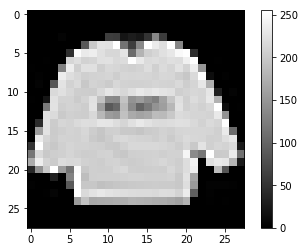

In [6]:
plt.figure()
plt.imshow(train_images.values[0].reshape(28,28), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c) Data preparation

In [7]:
# use maximum normalization
train_images = train_images / np.float32(255)

In [8]:
train_images.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.019608,0.0,0.0,...,0.000000,0.0,0.0,0.117647,0.168627,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.003922,0.007843,0.0,0.0,0.000000,0.0,0.0,...,0.011765,0.0,0.0,0.000000,0.000000,0.003922,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0



## 2. Model specific data preparation (tensorflow)
## a) Load the data

In [9]:
x_train_pt = torch.from_numpy(train_images.values.reshape((-1, 1, 28, 28)))

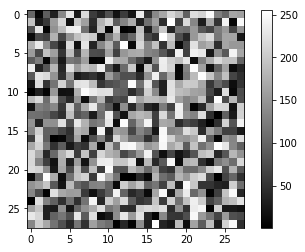

In [10]:
# use random seed to create fake input data
seed = torch.rand((28,28))
seed_im = seed.numpy() * 255
plt.figure()
plt.imshow(seed_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### b) Tensor view of the data

In [11]:
x_train_pt.shape

torch.Size([60000, 1, 28, 28])

In [12]:
seed.shape

torch.Size([28, 28])

In [13]:
x_train_pt[0][0][5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1843, 0.9882, 0.9176, 0.9333,
        0.8784, 0.8431, 0.8431, 0.8980, 0.4235, 0.7059, 0.8118, 0.8392, 0.8784,
        0.9059, 0.9765, 0.9961, 0.1765, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], dtype=torch.float64)

## 3. Model definition

In [14]:
def weights_init(m):
  if isinstance(m, nn.Linear):
      nn.init.uniform_(m.weight.data, -1,1)
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.Conv2d):
      nn.init.zeros_(m.bias.data)
  if isinstance(m, nn.ConvTranspose2d):
      nn.init.zeros_(m.bias.data)

In [15]:
class Reshape(nn.Module):
    def __init__(self, channels, height, width):
        super(Reshape, self).__init__()
        self.shape = (channels, height, width)

    def forward(self, x):
        return x.view(self.shape)

### a.1) Generator

In [16]:
def generator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.ConvTranspose2d(100, 64, 7, stride=1, padding=0, bias=True))
    #model.add_module("Reshape", Reshape(64, 7, 7))
    model.add_module("Batchnorm1", nn.BatchNorm2d(64))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    
    model.add_module("Conv2D2", nn.ConvTranspose2d(64, 32, (8,8), stride=(1,1), padding=0, bias=True))
    model.add_module("Batchnorm2", nn.BatchNorm2d(32))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.ConvTranspose2d(32, 1, (15,15), stride=1, padding=0, bias=True))
    model.add_module("Batchnorm3", nn.BatchNorm2d(1))
    model.add_module("Sigmoid1", nn.Sigmoid())
    return model
generator = generator_model()
#generator.eval()

In [17]:
# generated image not trained
fake_im_not_trained = generator(torch.rand([1, 100, 1, 1]))
# check output shape of generator
fake_im_not_trained.shape

torch.Size([1, 1, 28, 28])

###  a.2) Inspect the generator model

In [18]:
print(generator)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)


In [19]:
generator.apply(weights_init)

Sequential(
  (Conv2D1): ConvTranspose2d(100, 64, kernel_size=(7, 7), stride=(1, 1))
  (Batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Conv2D2): ConvTranspose2d(64, 32, kernel_size=(8, 8), stride=(1, 1))
  (Batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): ConvTranspose2d(32, 1, kernel_size=(15, 15), stride=(1, 1))
  (Batchnorm3): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Sigmoid1): Sigmoid()
)

### a.3) Inspect the first convolutional layer

In [21]:
generator[0].weight[0]

tensor([[[ 1.6328e-02,  1.7615e-02,  8.2604e-03,  ..., -3.3326e-03,
           1.4233e-02, -8.3214e-03],
         [ 1.1776e-02,  9.9213e-03, -1.6468e-02,  ...,  2.0714e-04,
           1.5016e-02, -1.6554e-02],
         [-4.8104e-03, -9.4442e-03,  1.5624e-02,  ...,  6.6118e-03,
          -9.1930e-03, -1.5254e-02],
         ...,
         [ 3.7296e-03, -1.6806e-02,  1.2434e-02,  ...,  3.6992e-03,
          -1.2552e-02, -3.3141e-03],
         [-1.0508e-02,  6.6893e-05,  1.1805e-02,  ...,  3.9716e-03,
          -2.1226e-03, -1.2533e-03],
         [-1.5324e-02,  1.2106e-02, -1.1942e-02,  ...,  1.1885e-02,
           7.1396e-03,  5.9327e-03]],

        [[ 6.8237e-03,  9.9446e-03,  1.7085e-02,  ..., -1.2294e-02,
           1.4818e-02, -1.4691e-02],
         [-1.0836e-02,  9.4204e-03, -1.7766e-02,  ..., -1.2872e-02,
           4.5527e-03,  6.1752e-03],
         [ 1.1630e-02,  1.5123e-02,  4.4301e-03,  ..., -1.7207e-02,
          -8.8413e-03,  3.8435e-03],
         ...,
         [-7.0201e-03,  1

In [22]:
generator[0].weight.shape

torch.Size([100, 64, 7, 7])

In [23]:
generator[0].bias

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True)

In [24]:
generator[0].bias.shape

torch.Size([64])

### b.1) Discriminator

In [20]:
def discriminator_model():
    model = nn.Sequential()
    model.add_module("Conv2D1", nn.Conv2d(1, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("Pooling1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("LeakyRelu1", nn.LeakyReLU())
    model.add_module("Dropout1", nn.Dropout(0.3))
    
    model.add_module("Conv2D2", nn.Conv2d(2, 2, kernel_size=5, stride=1, padding=2))
    model.add_module("LeakyRelu2", nn.LeakyReLU())
    
    model.add_module("Conv2D3", nn.Conv2d(2, 1, kernel_size=5, stride=1, padding=0))
    model.add_module("LeakyRelu3", nn.LeakyReLU())
    
    model.add_module("Flatten1", nn.Flatten())
    
    model.add_module("Dense1", nn.Linear(100,100))
    model.add_module("LeakyRelu4", nn.LeakyReLU())
    
    model.add_module("Dense2", nn.Linear(100,64))
    model.add_module("Tanh", nn.Tanh())
    
    model.add_module("Dense3", nn.Linear(64,1))
    model.add_module("Sigmoid", nn.Sigmoid())
    return model
discriminator = discriminator_model()
#discriminator = discriminator.float()

### b.2) Inspect the discriminator model

In [21]:
print(discriminator)
discriminator(fake_im_not_trained)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)


tensor([[0.4823]], grad_fn=<SigmoidBackward>)

In [22]:
discriminator.apply(weights_init)

Sequential(
  (Conv2D1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (LeakyRelu1): LeakyReLU(negative_slope=0.01)
  (Dropout1): Dropout(p=0.3, inplace=False)
  (Conv2D2): Conv2d(2, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (LeakyRelu2): LeakyReLU(negative_slope=0.01)
  (Conv2D3): Conv2d(2, 1, kernel_size=(5, 5), stride=(1, 1))
  (LeakyRelu3): LeakyReLU(negative_slope=0.01)
  (Flatten1): Flatten(start_dim=1, end_dim=-1)
  (Dense1): Linear(in_features=100, out_features=100, bias=True)
  (LeakyRelu4): LeakyReLU(negative_slope=0.01)
  (Dense2): Linear(in_features=100, out_features=64, bias=True)
  (Tanh): Tanh()
  (Dense3): Linear(in_features=64, out_features=1, bias=True)
  (Sigmoid): Sigmoid()
)

### b.3) Inspect the first convolutional layer

In [28]:
discriminator[0].weight[0].type()

'torch.FloatTensor'

In [29]:
discriminator[0].weight.shape

torch.Size([2, 1, 5, 5])

In [30]:
discriminator[0].bias

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [31]:
discriminator[0].bias.shape

torch.Size([2])

## 4. Loss & Optimizer

### 4.a) Generator loss

In [23]:
cross_entropy = nn.BCEWithLogitsLoss()
def generator_loss(fake_output):
    return cross_entropy(torch.ones_like(fake_output), fake_output)

### 4.b) Discriminator loss

In [24]:
def real_discriminator_loss(real_output):
    return  real_loss = cross_entropy(torch.ones_like(real_output), real_output)

def fake_discriminator_loss(fake_output):
    return cross_entropy(torch.zeros_like(fake_output), fake_output)

## 4.c) Optimizers

In [25]:
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

#train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy') # only for discriminator

def correct_classification(y_true, y_prob):
    assert y_true.size() == y_prob.size()
    y_prob = (y_prob > 0.5).float()
    return (y_true == y_prob).sum().item()

## 5. Training

In [26]:
# This annotation causes the function to be "compiled".
#@tf.function
def train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer, batch_size = 100):
    gen_loss_tot = []
    disc_loss_tot = []
    disc_acc_real_tot = 0
    disc_acc_fake_tot = 0
    generator.train()
    discriminator.train()
    for beg_i in range(0, x_train_pt.shape[0], batch_size):
        x_train_batch_pt = x_train_pt[beg_i:beg_i + batch_size]

        x_fake_batch_pt = torch.rand([batch_size, 100, 1, 1])
        
        discriminator_optimizer.zero_grad()
        real_output = discriminator(x_train_batch_pt.float()).view(-1)
        disc_loss_real = real_discriminator_loss(real_output)
        disc_loss_real.backward()
        
        generated_images = generator(x_fake_batch_pt)
        fake_output = discriminator(generated_images.detach()).view(-1)
        disc_loss_fake = fake_discriminator_loss(fake_output)
        disc_loss_fake.backward()
        err = disc_loss_fake + disc_loss_real
        discriminator_optimizer.zero_grad()
        
        # optimize generator
        generator_optimizer.zero_grad()
        fake_output = discriminator(generated_images.detach()).view(-1)
        gen_loss = generator_loss(fake_output)
        gen_loss.backward()
        generator_optimizer.step()
        
        gen_loss_tot.append(gen_loss.mean().item())
        disc_loss_tot.append(err.mean().item())
        disc_acc_real_tot += correct_classification(torch.ones_like(real_output), real_output)
        disc_acc_fake_tot += correct_classification(torch.zeros_like(fake_output), fake_output)

    disc_acc_real_tot = disc_acc_real_tot/x_train_pt.size(0)
    disc_acc_fake_tot = disc_acc_fake_tot/x_train_pt.size(0)
    disc_acc_tot = np.mean([disc_acc_real_tot, disc_acc_fake_tot])
    return gen_loss_tot, disc_loss_tot, disc_acc_tot

In [27]:
train_losses_generator_pt = []
train_losses_discriminator_pt = []
train_acc_discriminator_pt = []
epochs = 15

for epoch in range(epochs):
    gen_loss, disc_loss, disc_acc = train_step_pt(generator, discriminator, generator_optimizer, discriminator_optimizer)
    gen_loss = np.mean(gen_loss)
    disc_loss = np.mean(disc_loss)
    train_losses_generator_pt.append(gen_loss)
    train_losses_discriminator_pt.append(disc_loss)
    train_acc_discriminator_pt.append(disc_acc*100)


    template = ("Epoch {}, Loss_Generator: {}, Loss_Discriminator: {}, Discriminator_Accuracy: {}")
    print(template.format(epoch+1, gen_loss, disc_loss, disc_acc*100))

Epoch 1, Loss_Generator: 0.8454136536518733, Loss_Discriminator: 1.519691140850385, Discriminator_Accuracy: 63.905


KeyboardInterrupt: 

### b) Training progress

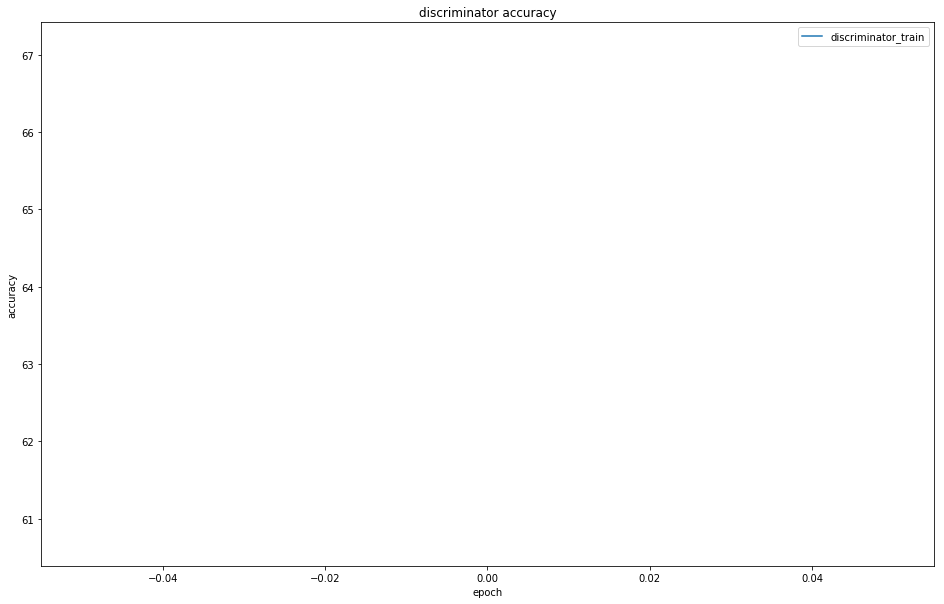

In [29]:
plt.figure(figsize=(16,10))
plt.plot(train_acc_discriminator_pt)
plt.title('discriminator accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['discriminator_train'], loc='upper right')
plt.show()

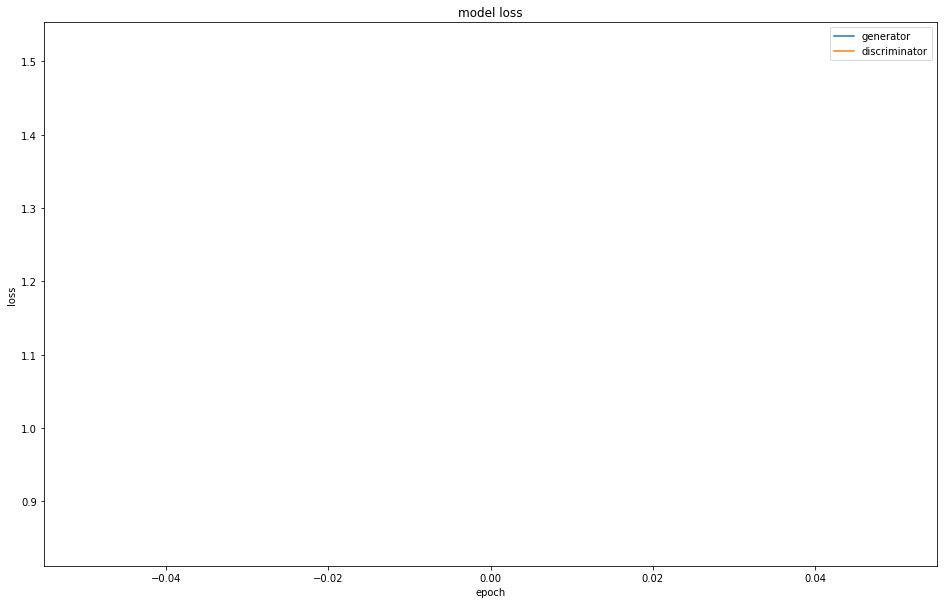

In [30]:
plt.figure(figsize=(16,10))
plt.plot(train_losses_generator_pt)
plt.plot(train_losses_discriminator_pt)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper right')
plt.show()

### c1) Generator output before training

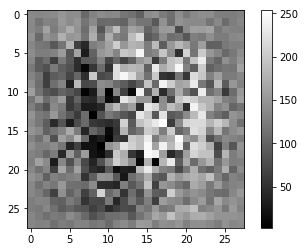

In [32]:
fake_im_not_trained = fake_im_not_trained.detach().numpy() * 255
fake_im_not_trained = fake_im_not_trained.reshape((28,28))
plt.figure()
plt.imshow(fake_im_not_trained, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### c2) Generator output after training

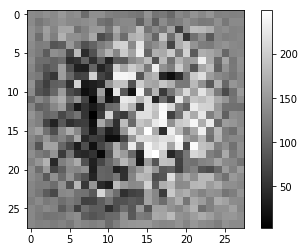

In [33]:
seed2 = torch.rand([1, 100, 1, 1])
generator.train(False)
fake_im = generator(seed2)
fake_im = fake_im.detach().numpy() * 255
fake_im = fake_im.reshape((28,28))
plt.figure()
plt.imshow(fake_im, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()